# SVM and GridSearchCV
- Name: **Trần Thanh Dương (SE160185)**
- Class: **AIL302m**

In this notebook, I will use SVM for classification and GridSearchCV for finding hyperparameters which give best performance.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import re
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.colors import ListedColormap
from mpl_toolkits import mplot3d
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import make_classification

In [ ]:
# Dataset url
DATASET_URL = "https://gist.githubusercontent.com/duongttr/ff8728ebd7601e67c7d9eca1e86663ce/raw/02b90bb36befb7a7ca95747eaf21309511f796de/Food.csv"

In [ ]:
# Watch how the dataset look like
df = pd.read_csv(DATASET_URL)
df.head(10)

,e,no. video,Student ID,Full name,id,standardized dish,dish occurence (based on transcript),dish imply,start time,end time,...,sauce (based on transcript),venue,container,describe how to make it,viewer feeling of youtuber's style,viewer feeling of presented food,YouTuber feeling,location,foreigner,Unnamed: 24
0,1.0,51.0,NaN,NaN,5OzrpNCyXqs,snail vermicelli soup,bun oc,NaN,1:05,3:21,...,NaN,street restaurant,bowl,1,4,NaN,5,HN,1,NaN
1,2.0,51.0,NaN,NaN,5OzrpNCyXqs,vermicelli with fried tofu and shrimp paste,bun dau mam tom,NaN,3:32,6:10,...,"fish sauce, fermented shrimp paste, pepper, ch...",street restaurant,tray,1,4,NaN,4,HN,1,NaN
2,3.0,51.0,NaN,NaN,5OzrpNCyXqs,fried spring roll,spring roll,NaN,5:23,6:10,...,"fish sauce, sweet spicy garlic sauce",street restaurant,plate,0,5,NaN,5,HN,1,NaN
3,4.0,51.0,NaN,NaN,5OzrpNCyXqs,steamed rolled rice pancake,banh cuon,NaN,6:22,9:23,...,"garlic water, fried caramelized scallion, pepp...",street restaurant,plate,1,5,NaN,5,HN,1,NaN
4,5.0,51.0,NaN,NaN,5OzrpNCyXqs,shrimp cake,shrimp cake,NaN,9:42,11:55,...,"chili, sweet spicy sauce",street restaurant,plate,1,4,NaN,5,HN,1,NaN
5,6.0,51.0,NaN,NaN,5OzrpNCyXqs,boiled snail,snails cooked in lemongrass,ốc bươu hấp sả,12:28,15:17,...,"fish sauce, chili, lime leaves, garlic, lemong...",casual restaurant,bowl,0,5,NaN,5,HN,1,NaN
6,7.0,51.0,NaN,NaN,5OzrpNCyXqs,rolling pho,pho cuon,NaN,15:20,18:25,...,"sweet fish sauce, green papaya",street restaurant,plate,1,5,NaN,5,HN,1,NaN
7,8.0,51.0,NaN,NaN,5OzrpNCyXqs,pho,pho tron,phở gà trộn,19:10,22:33,...,NaN,street restaurant,bowl,1,5,NaN,5,HN,1,NaN
8,9.0,52.0,NaN,NaN,3qfTtx3yG5U,banh mi,banh mi,NaN,2:03,2:18,...,NaN,casual restaurant,bag,1,3,NaN,3,HN,1,NaN
9,10.0,52.0,NaN,NaN,3qfTtx3yG5U,egg coffee,coffee,NaN,2:26,2:52,...,NaN,casual restaurant,glass,0,4,NaN,4,HN,1,NaN


In [ ]:
# Required features for training model
features = ['start time', 'end time', 'Unnamed: 11', 'venue', 'container', 'describe how to make it',
            'viewer feeling of youtuber\'s style ']

data = df[features].dropna() # Firstly, drop all NaN value in dataset

# Remove all unknown values
data = data[data['start time'].str.contains('start') == False]
data = data[data['start time'].str.contains('Start') == False]
data = data[data['end time'].str.contains('x') == False]
data = data[data['end time'].str.contains('end') == False]
data = data[data['end time'].str.contains('End') == False]
data = data[data['end time'].str.contains('x') == False]

# Rename columns' names
data = data.rename(columns={'Unnamed: 11': 'ingre_count', 'describe how to make it': 'is_described', 
             "viewer feeling of youtuber\'s style ": 'feeling'})

# Convert feeling type
data['feeling'] = data['feeling'].astype(int).replace({0: 1})

# Replace unspecificed values
data['venue'] = data['venue'].replace({'boat restaurant': 'other', 'home': 'other'})
data['container']=data['container'].replace(
              {'hand': 'hands-on', 'no': 'hands-on', 'clay bot': 'pot', 'tray ': 'tray',
              'plastic glass': 'glass', 'Bag': 'bag', 'cup': 'glass'})

data=data[data['is_described'] != '3']
data['is_described']=data['is_described'].astype(int)

# Calculate duration
pattern = '(\d+).*?[;:].*?(\d+)'
def calculate_duration(row):
  import re
  pattern = '(\d+).*?[;:.].*?(\d+)'
  start_time = row[0]
  end_time = row[1]

  try:
    start_min, start_sd = list(map(int, re.findall(pattern, start_time)[0]))
    end_min, end_sd = list(map(int, re.findall(pattern, end_time)[0]))
  except:
    print(row)
    return 0

  return end_min * 60 + end_sd - (start_min *60 + start_sd)

data['duration'] = data.apply(calculate_duration, axis=1)
data = data[data['duration'] > 0]

data=data.drop(labels=['start time', 'end time'], axis=1)

data['venue']=data['venue'].replace({v: k for k, v in dict(enumerate(data['venue'].unique())).items()})
data['container']=data['container'].replace({v: k for k, v in dict(enumerate(data['container'].unique())).items()})

OH_venue = pd.get_dummies(data['venue'], 'venue')
OH_container = pd.get_dummies(data['container'], 'container')

data=data.drop(labels=['venue', 'container'], axis=1)
data=data.join([OH_venue, OH_container])

y = data['feeling']
X = data.drop('feeling', axis=1)
# Make feature more-likely normal distribution
X['duration'] = np.log(X['duration'] + 1e-8)
X['ingre_count'] = np.log(X['ingre_count'] + 0.05)

In [ ]:
X.head(10)

,ingre_count,is_described,duration,venue_0,venue_1,venue_2,venue_3,container_0,container_1,container_2,container_3,container_4,container_5,container_6,container_7,container_8,container_9
0,2.202765,1,4.912655,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2.402430,1,5.062595,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1.398717,0,3.850148,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1.619388,1,5.198497,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1.398717,1,4.890349,1,0,0,0,0,0,1,0,0,0,0,0,0,0
5,1.619388,0,5.129899,0,1,0,0,1,0,0,0,0,0,0,0,0,0
6,1.953028,1,5.220356,1,0,0,0,0,0,1,0,0,0,0,0,0,0
7,2.836150,1,5.313206,1,0,0,0,1,0,0,0,0,0,0,0,0,0
8,1.619388,1,2.708050,0,1,0,0,0,0,0,1,0,0,0,0,0,0
9,1.115142,0,3.258097,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X, y)

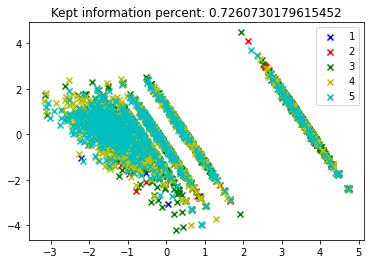

In [ ]:
plt.scatter(X_transformed[y == 1][:, 0],X_transformed[y == 1][:, 1], c='b', marker='x', label='1')
plt.scatter(X_transformed[y == 2][:, 0],X_transformed[y == 2][:, 1], c='r', marker='x', label='2')
plt.scatter(X_transformed[y == 3][:, 0],X_transformed[y == 3][:, 1], c='g', marker='x', label='3')
plt.scatter(X_transformed[y == 4][:, 0],X_transformed[y == 4][:, 1], c='y', marker='x', label='4')
plt.scatter(X_transformed[y == 5][:, 0],X_transformed[y == 5][:, 1], c='c', marker='x', label='5')
plt.title("Kept information percent: " + str(pca.explained_variance_ratio_.sum()))
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=99)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, test_size=0.2, stratify=y)

y_train = y_train.to_numpy() - np.ones_like(y_train)
y_test = y_test.to_numpy() - np.ones_like(y_test)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
svc = SVC(C=1000, kernel="rbf")
svc.fit(X_train, y_train)

print("---Train---")
y_train_pred = svc.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred, average='weighted'))
print("Recall:", recall_score(y_train, y_train_pred, average='weighted'))
print("F1-Score:", f1_score(y_train, y_train_pred, average='weighted'))

print("---Test---")
y_test_pred = svc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_test_pred, average='weighted'))
print("F1-Score:", f1_score(y_test, y_test_pred, average='weighted'))

---Train---
Accuracy: 0.5488904299583911
Precision: 0.579693738489449
Recall: 0.5488904299583911
F1-Score: 0.5321202345479094
---Test---
Accuracy: 0.42382271468144045
Precision: 0.42415715627847933
Recall: 0.42382271468144045
F1-Score: 0.4114775807197296


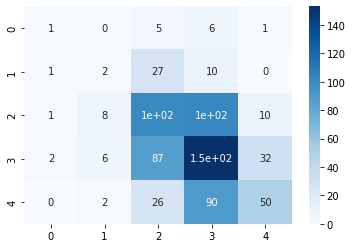

In [ ]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues')

In [ ]:
svc = SVC(C=1000, kernel="rbf")
svc.fit(X_train_resampled, y_train_resampled)

print("---Train---")
y_train_pred = svc.predict(X_train_resampled)
print("Accuracy:", accuracy_score(y_train_resampled, y_train_pred))
print("Precision:", precision_score(y_train_resampled, y_train_pred, average='weighted'))
print("Recall:", recall_score(y_train_resampled, y_train_pred, average='weighted'))
print("F1-Score:", f1_score(y_train_resampled, y_train_pred, average='weighted'))

print("---Test---")
y_test_pred = svc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_test_pred, average='weighted'))
print("F1-Score:", f1_score(y_test, y_test_pred, average='weighted'))

---Train---
Accuracy: 0.6223214285714286
Precision: 0.6078036547378796
Recall: 0.6223214285714286
F1-Score: 0.6042691679907265
---Test---
Accuracy: 0.3185595567867036
Precision: 0.3994777878471239
Recall: 0.3185595567867036
F1-Score: 0.3306947713080121


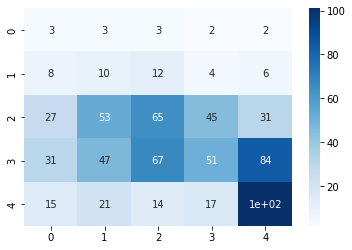

In [ ]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues')

In [ ]:
from sklearn.model_selection import GridSearchCV

# SVM + GridSearchCV + without oversampling dataset

In [ ]:
parameters = [{'C': [1, 10, 100], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'gamma': ['scale', 'auto', 1, 0.1, 0.01], 'kernel': ['rbf']},
              {'C': [1, 10, 100], 'coef0': [0, 0.5, 1], 'gamma': ['scale', 'auto', 1, 0.1, 0.01], 'kernel': ['sigmoid']},
              {'C': [1, 10], 'degree': [2],  'gamma': ['scale', 'auto', 1, 0.1, 0.01], 'kernel': ['poly']}]

clf = GridSearchCV(SVC(random_state=99), 
                   parameters, scoring='accuracy', verbose=4)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
print("Best estimator:", clf.best_estimator_)
print("Best score:",clf.best_score_)
print("Best params:",clf.best_params_)
print("Best index:",clf.best_index_)

In [ ]:
df = pd.DataFrame(clf.cv_results_)
df.to_csv('result.csv')

In [ ]:
best_C = clf.best_estimator_.C
best_gamma = clf.best_estimator_.gamma
best_kernel = clf.best_estimator_.kernel
final_svc = SVC(C=best_C, gamma=best_gamma, kernel=best_kernel)

final_svc.fit(X_train, y_train)

In [ ]:
print("---Train---")
y_train_pred = final_svc.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_train, y_train_pred, average='weighted', zero_division=0))
print("F1-Score:", f1_score(y_train, y_train_pred, average='weighted', zero_division=0))

print("---Test---")
y_test_pred = final_svc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_test_pred, average='weighted', zero_division=0))
print("F1-Score:", f1_score(y_test, y_test_pred, average='weighted', zero_division=0))

In [ ]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues')

# SVM + GridSearchCV + oversampling dataset

In [ ]:
clf_2 = GridSearchCV(SVC(random_state=99), 
                   parameters, scoring='accuracy', n_jobs=-1, verbose=True)

In [ ]:
clf_2.fit(X_train_resampled, y_train_resampled)

In [ ]:
print("Best estimator:", clf_2.best_estimator_)
print("Best score:",clf_2.best_score_)
print("Best params:",clf_2.best_params_)
print("Best index:",clf_2.best_index_)

In [ ]:
df_2 = pd.DataFrame(clf_2.cv_results_)
df_2.to_csv('result_2.csv')

In [ ]:
best_C = clf_2.best_estimator_.C
best_gamma = clf_2.best_estimator_.gamma
best_kernel = clf_2.best_estimator_.kernel
final_svc_2 = SVC(C=best_C, gamma=best_gamma, kernel=best_kernel)

final_svc_2.fit(X_train_resampled, y_train_resampled)

In [ ]:
print("---Train---")
y_train_pred = final_svc_2.predict(X_train_resampled)
print("Accuracy:", accuracy_score(y_train_resampled, y_train_pred))
print("Precision:", precision_score(y_train_resampled, y_train_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_train_resampled, y_train_pred, average='weighted', zero_division=0))
print("F1-Score:", f1_score(y_train_resampled, y_train_pred, average='weighted', zero_division=0))

print("---Test---")
y_test_pred = final_svc_2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_test_pred, average='weighted', zero_division=0))
print("F1-Score:", f1_score(y_test, y_test_pred, average='weighted', zero_division=0))

In [ ]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues')

# How C and gamma affect the results

In [ ]:
matplotlib_axes_logger.setLevel('ERROR')
zero_one_colourmap_pts = ListedColormap(('red', 'green'))
zero_one_colourmap_boundary = ListedColormap(('#FFCCCB', '#90EE90'))

In [ ]:
def plot_decision_boundary(X, y, clf):
  X_set, y_set = X, y
  X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, 
                                 stop = X_set[:, 0].max() + 1, 
                                 step = 0.01),
                       np.arange(start = X_set[:, 1].min() - 1, 
                                 stop = X_set[:, 1].max() + 1, 
                                 step = 0.01))
  plt.figure(figsize=(5,5))
  plt.contourf(X1, X2, clf.predict(np.array([X1.ravel(), 
                                             X2.ravel()]).T).reshape(X1.shape),
               alpha = 0.75, 
               cmap = zero_one_colourmap_boundary)
  plt.xlim(X1.min(), X1.max())
  plt.ylim(X2.min(), X2.max())
  for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = (zero_one_colourmap_pts)(i), label = j)
  plt.title('SVM Decision Boundary')
  plt.xlabel('X1')
  plt.ylabel('X2')
  plt.legend()
  return plt.show()

In [ ]:
def generate_clf(input_gamma, input_C=1):
  classifier = SVC(kernel="rbf", gamma=input_gamma, C=input_C)
  classifier.fit(X, y.ravel())
  y_pred = classifier.predict(X)
  print("Training Accuracy = {}".format(accuracy_score(y_pred, y)))
  return classifier

In [ ]:
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, random_state=1)

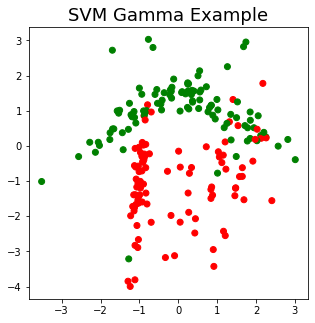

In [ ]:
plt.figure(figsize=(5,5))
plt.title("SVM Gamma Example", fontsize=18)
plt.scatter(X[:,0], X[:,1], c=y, cmap=zero_one_colourmap_pts)

## Gamma

Training Accuracy = 0.88


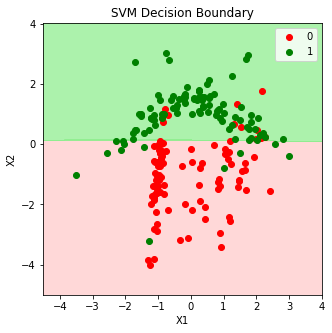

In [ ]:
classifier_1 = generate_clf(0.0001, 1000)
plot_decision_boundary(X, y, classifier_1)

Training Accuracy = 0.915


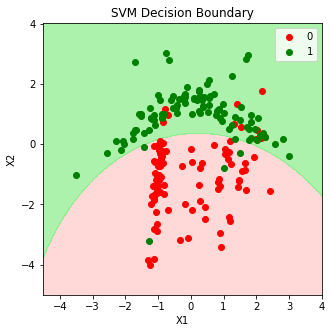

In [ ]:
classifier_2 = generate_clf(0.001, 1000)
plot_decision_boundary(X, y, classifier_2)

Training Accuracy = 0.915


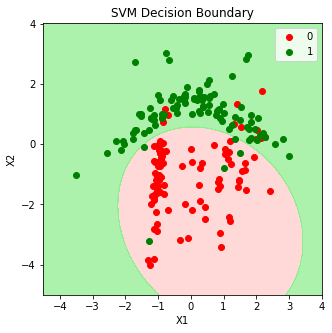

In [ ]:
classifier_3 = generate_clf(0.01, 1000)
plot_decision_boundary(X, y, classifier_3)

# C

Training Accuracy = 0.88


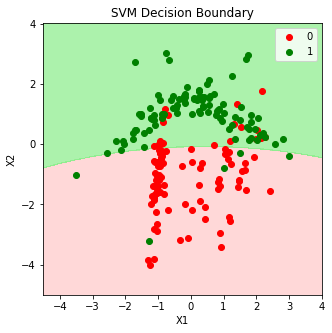

In [ ]:
classifier_4 = generate_clf(0.01, 1)
plot_decision_boundary(X, y, classifier_4)

Training Accuracy = 0.92


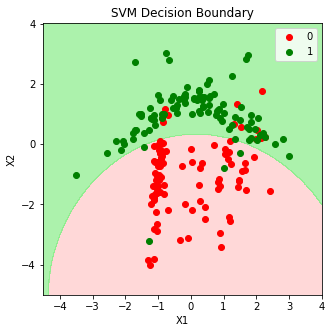

In [ ]:
classifier_5 = generate_clf(0.01, 10)
plot_decision_boundary(X, y, classifier_5)

Training Accuracy = 0.92


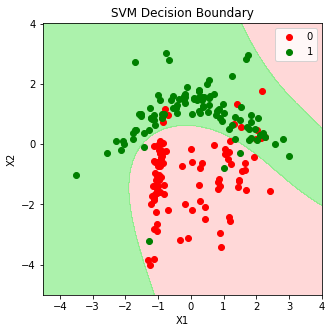

In [ ]:
classifier_6 = generate_clf(0.01, 10000)
plot_decision_boundary(X, y, classifier_6)